In [2]:
import gym
help(gym.make('CartPole-v0'))

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env, max_episode_steps=None)
 |  
 |  Wraps the environment to allow a modular transformation.
 |  
 |  This class is the base class for all wrappers. The subclass could override
 |  some methods to change the behavior of the original environment without touching the
 |  original code.
 |  
 |  .. note::
 |  
 |      Don't forget to call ``super().__init__(env)`` if the subclass overrides :meth:`__init__`.
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env, max_episode_steps=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  reset(self, **kwargs)
 |      Resets the environment to an initial state and returns an initial
 |      observation.
 |      
 |      Note that this function should not reset the environment's ra

In [ ]:
import torch
import torch.nn as nn
import sys,os
import torch.nn.functional as F
import datetime
import torch.optim as optim
from utils import ReplayBuffer
import math
import random

curr_path = os.path.dirname(os.path.abspath(__file__)) # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path) # 父路径
sys.path.append(parent_path) # 添加父路径到系统路径sys.path
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间

class path_env(torch.nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, n_items, n_users, emb_size):
        '''环境模型设置为一个GRU，用于计算用户状态表征和奖励函数
        '''
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 初始化环境
        self.env = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # item embedding 使用 KG 上预训练的结果
        self.item_embedding = nn.Embedding(n_items, emb_size)
        self.user_embedding = nn.Embedding(n_users, emb_size)
        # 先使用交叉熵损失
        self.loss_func = nn.CrossEntropyLoss()
        self.dense = nn.Linear(self.hidden_size, emb_size)
        self.act = nn.Softmax()
    
    def reset(self):
        # 返回初始状态
        return

    def set_for_user(self, uid, item_id_list, seq_len, utime, target):
        self.uid = uid
        self.u_emb = self.user_embedding(uid)
        self.item_id_list = item_id_list
        self.seq_len = seq_len
        self.target = target
        self.utime = utime

    def step(self, action):
        '''根据动作，计算奖励函数、下一个状态
        '''
        # 需要获取当前序列，当前学习场景向量
        if self.seq_len == len(self.item_id_list):
            self.item_id_list = self.item_id_list[1:]+action
        else:
            self.item_id_list[self.seq_len] = action
            self.seq_len += 1
        item_seq_emb = self.item_embedding(self.item_id_list)
        gru_output,_ = self.gru(item_seq_emb)
        gru_output = self.dense(gru_output)
        seq_output =  self.gather_indexes(gru_output, self.seq_len)
        # 拼接场景向量、用户向量、序列向量
        next_state = 
        # 奖励函数包括两个部分，一个是当前动作和target的相似度，一个是路径相似度
        path_reward = 
        unit_reward = F.cosine_similarity(,,dim=0)
        reward = 
        # 判断是否完成目标
        done = (action==target)
        info = "state updata with action"
        return next_state, reward, done, info

    

class DQNConfig:
    def __init__(self):
        self.algo = "DQN"  # 算法名称
        self.env = 'path' # 环境名称
        # 保存结果的路径
        self.result_path = curr_path+"/outputs/" + self.env + '/'+curr_time+'/results/'  
        # 保存模型的路径
        self.model_path = curr_path+"/outputs/" + self.env + '/'+curr_time+'/models/'  
        self.train_eps = 200 # 训练的回合数
        self.eval_eps = 30 # 测试的回合数
        self.gamma = 0.95 # 强化学习中的折扣因子
        self.epsilon_start = 0.90 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.lr = 0.0001  # 学习率
        self.memory_capacity = 100000  # 经验回放的容量
        self.batch_size = 64 # mini-batch SGD中的批量大小
        self.target_update = 4 # 目标网络的更新频率
        # 检测GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
        self.hidden_dim = 256  # hidden size of net

class MLP(nn.Module):
    def __init__(self, input_dim,output_dim,hidden_dim=128):
        """ 初始化q网络，为全连接网络
            input_dim: 输入的特征数即环境的状态数
            output_dim: 输出的动作维度
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, output_dim) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQN:
    def __init__(self, state_dim, action_dim, cfg):
        self.action_dim = action_dim  # 总的动作个数
        self.device = cfg.device  # 设备，cpu或gpu等
        self.gamma = cfg.gamma  # 奖励的折扣因子
        # e-greedy策略相关参数
        self.frame_idx = 0  # 用于epsilon的衰减计数
        self.epsilon = lambda frame_idx: cfg.epsilon_end + (cfg.epsilon_start - cfg.epsilon_end) * math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(state_dim, action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = MLP(state_dim, action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): # 复制参数到目标网路targe_net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # 优化器
        self.memory = ReplayBuffer(cfg.memory_capacity)

    def choose_action(self, state):
        '''选择动作
        在路径推荐时，这一步对应输入状态为一个表征向量，输出预测的下一个交互对象
        使用 policy net 完成 q值 计算，选择最大的
        '''
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor([state], device=self.device, dtype=torch.float32)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 选择Q值最大的动作
        else:
            action = random.randrange(self.action_dim)
        return action

    def predict(self,state):
        # 利用 policy net 完成 动作预测，区别是这里不使用e-greedy
        with torch.no_grad():
            state = torch.tensor([state], device=self.device, dtype=torch.float32)
            q_values = self.policy_net(state)
            action = q_values.max(1)[1].item()
        return action

    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中(replay memory)中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 转为张量
        state_batch = torch.tensor(
            state_batch, device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(
            1)  
        reward_batch = torch.tensor(
            reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(
            next_state_batch, device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(
            done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        for param in self.policy_net.parameters():  # clip防止梯度爆炸
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

    def save(self, path):
        torch.save(self.target_net.state_dict(), path+'dqn_checkpoint.pth')

    def load(self, path):
        self.target_net.load_state_dict(torch.load(path+'dqn_checkpoint.pth'))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)
 

In [ ]:
def train(cfg, env, agent):
    print('开始训练!')
    print(f'环境：{cfg.env}, 算法：{cfg.algo}, 设备：{cfg.device}')
    rewards = [] # 记录奖励
    ma_rewards = []  # 记录滑动平均奖励
    for i_ep in range(cfg.train_eps):
        # 初始化状态
        # 需要设计一个dataloader，读取数据，然后计算状态，计算奖励函数。。。
        state = env.reset()
        done = False
        ep_reward = 0
        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            # 相当于forward
            agent.update()
            if done:
                break
        if (i_ep+1) % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i_ep+1)%10 == 0:
            print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        # save ma_rewards
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('完成训练！')
    return rewards, ma_rewards

In [ ]:
config = DQNConfig()
env = path_env()
agent = DQN(state_dim=,action_dim=,cfg=config)

In [4]:
import nltk
 
sen = [str(x) for x in [0,1,2,3,5]]
can = [str(x) for x in [0,1,2,3,4]]
nltk.translate.bleu_score.sentence_bleu(sen,can)

/opt/conda/envs/KT_RL/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/KT_RL/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/envs/KT_RL/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

1.7229823170315744e-231

In [ ]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        #print si
        ref_counts = []
        ref_lengths = []
        #print references
        # Build dictionary of ngram counts
        for reference in references:
            #print 'reference' + reference
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    
    return bp


def geometric_mean(precisions):
    x = 1
    for p in precisions:
        x *= p
    return x ** (1.0 / len(precisions))


def BLEU(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
        print('P'+str(i+1), ' = ',round(pr, 2))
    print('BP = ',round(bp, 2))
    bleu = geometric_mean(precisions) * bp
    return bleu

In [23]:
def count_ngram(candidate, references, n):
    count = 0
    # candidate中连续n个和references中连续n个的匹配次数
    can_seq = []
    for i in range(len(candidate)-n+1):
        temp = candidate[i:i+n]
        temp = [str(x) for x in temp]
        temp = ','.join(temp)
        can_seq.append(temp)
    can_seq = set(can_seq)
    print(can_seq)
    for i in range(len(references)-n+1):
        temp2 = references[i:i+n]
        temp2 = [str(x) for x in temp2]
        temp2 = ','.join(temp2)
        print(temp2)
        if temp2 in can_seq:
            count += 1
    c = len(candidate) - n + 1
    r = len(references) - n + 1
    if c < r:
        bp = math.exp(1-(float(r)/c))
    elif c == r:
        bp = 1
    else:
        bp = math.exp(1-(float(c)/r))
    print("r:",r,"c:",c)
    pr = count/(max(r,c)+0.000001)
    return pr, bp

In [26]:
import math

def geometric_mean(precisions):
    x = 1
    for p in precisions:
        x *= p
    return x ** (1.0 / len(precisions))


def BLEU(candidate, references):
    precisions = []
    s = min(len(candidate),len(references))
    for i in range(s-1):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
        print('P'+str(i+1), ' = ',round(pr, 2),'bp:',bp)
    print('BP = ',round(bp, 2))
    bleu = sum(precisions)/(len(precisions)+0.00001)
    return bleu


BLEU([0,1,3,5],[0,2,1,3,5])

{'5', '0', '1', '3'}
0
2
1
3
5
r: 5 c: 4
P1  =  0.8 bp: 0.7788007830714049
{'1,3', '0,1', '3,5'}
0,2
2,1
1,3
3,5
r: 4 c: 3
P2  =  0.5 bp: 0.7165313105737893
{'0,1,3', '1,3,5'}
0,2,1
2,1,3
1,3,5
r: 3 c: 2
P3  =  0.33 bp: 0.6065306597126334
BP =  0.61


0.5444424975991156

In [28]:
BLEU([0,1,3,5],[2,1,3,5])

{'5', '0', '1', '3'}
2
1
3
5
r: 4 c: 4
P1  =  0.75 bp: 1
{'1,3', '0,1', '3,5'}
2,1
1,3
3,5
r: 3 c: 3
P2  =  0.67 bp: 1
{'0,1,3', '1,3,5'}
2,1,3
1,3,5
r: 2 c: 2
P3  =  0.5 bp: 1
BP =  1


0.6388865393597656

In [34]:
import random
random.randint(0,3)

0

In [53]:
import pandas as pd
# load data and preprocess it
columns = ['userid', 'itemid', 'behavior', 'timestamp']
data = pd.read_csv('./data/java/java_mb_KG.txt', sep='\t', names=columns)
# 对每一列数据进行空缺值处理
for field in columns:
    data[field].fillna(value='', inplace=True)
# 先对数据按照user和时间戳升序排列
data.sort_values(by=['userid','timestamp'], inplace=True, ascending=True)
print(len(data))
data.drop_duplicates(subset=['userid','itemid'],keep='first',inplace=True)
data

2494


,userid,itemid,behavior,timestamp
0,1,305,watch,1406863244
1,1,172,done,1410874261
2,1,54,done,1410874265
4,1,314,done,1410913417
5,1,1,tag,1410925379
...,...,...,...,...
2484,183,300,done,1411630044
2485,183,363,enter,1415934808
2487,183,1,watch,1418687894
2489,183,294,done,1429083169


In [47]:
import numpy as np
def fill_seq(x, length):
    # 此函数用来将序列补齐为统一长度
    n = len(x)
    if n>=length:
        return x[:length]
    else:
        a = [0]*(length-n)
        x.extend(a)
        return np.array(x)

def filter_user(inter_seq):
    # 此函数用于过滤一些交互过少的用户
    inter_seq['seq_len'] = inter_seq['itemid'].apply(lambda x: len(x))
    user_id = inter_seq[inter_seq['seq_len']>=min_item_list_len]['userid']
    return user_id
    
max_item_list_len = 100
min_item_list_len = 3

In [56]:
# 再根据用户聚合，得到交互序列和评分序列
inter_seq = data.groupby('userid').agg({'itemid':'unique'}).reset_index()
inter_seq

,userid,itemid
0,1,"[305, 172, 54, 314, 1, 350, 352, 301, 302, 310..."
1,2,"[363, 1]"
2,3,"[363, 294, 173, 297, 322, 301, 311, 310, 1, 29..."
3,4,"[363, 1]"
4,5,"[1, 294, 363]"
...,...,...
178,179,"[294, 295, 35, 297, 298, 300, 1, 301]"
179,180,[1]
180,181,"[363, 1]"
181,182,"[294, 54, 1]"


In [65]:
# 数据清洗——需要filter一些交互过少的用户,得到保留的
user_id = filter_user(inter_seq)
# self.data = self.data[self.data['user_id:token']]
# 对保留的数据，找到每个用户最后一个交互的作为test
test_data = data.drop_duplicates(subset=['userid'],keep='last')
data = data[~data.index.isin(test_data.index)]
# 得到过滤后的交互数据
new_inter_seq = data.groupby('userid').agg({'itemid':'unique'}).reset_index()
new_inter_seq

,userid,itemid
0,1,"[305, 172, 54, 314, 1, 350, 352, 301, 302, 310..."
1,3,"[363, 294, 173, 297, 322, 301, 311, 310, 1]"
2,5,[1]
3,6,"[1, 363, 297, 300, 310, 314, 312, 301, 302, 31..."
4,7,[294]
...,...,...
91,177,[1]
92,178,"[298, 311]"
93,179,"[294, 295, 35, 297, 298, 300]"
94,182,[294]


In [80]:
behave_seq = data.groupby('userid').agg({'behavior':'unique'}).reset_index()
new_inter_seq = new_inter_seq[new_inter_seq['userid'].isin(user_id)]
new_inter_seq

,userid,itemid,pos_item,seq_len
0,1,"[305, 172, 54, 314, 1, 350, 352, 301, 302, 310...",331,100
1,3,"[363, 294, 173, 297, 322, 301, 311, 310, 1, 0,...",295,100
2,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",294,100
3,6,"[1, 363, 297, 300, 310, 314, 312, 301, 302, 31...",361,100
4,7,"[294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,100
...,...,...,...,...
91,177,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",337,100
92,178,"[298, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,100
93,179,"[294, 295, 35, 297, 298, 300, 0, 0, 0, 0, 0, 0...",1,100
94,182,"[294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",54,100


In [67]:
behave_seq

,userid,behavior
0,1,"[watch, done, tag, duration]"
1,3,"[enter, duration, done, watch]"
2,5,[tag]
3,6,"[watch, enter, duration, done]"
4,7,[duration]
...,...,...
91,177,[tag]
92,178,"[done, tag]"
93,179,"[done, tag]"
94,182,[duration]


In [68]:
test_data = test_data[['userid','itemid']]
test_data.rename(columns={'itemid':'pos_item'}, inplace=True)
test_data

,userid,pos_item
62,1,331
76,2,363
96,3,295
100,4,363
105,5,294
...,...,...
2453,178,1
2468,179,1
2476,181,363
2481,182,54


In [69]:
new_inter_seq = pd.merge(new_inter_seq, test_data, on='userid', how='inner')
new_inter_seq

,userid,itemid,pos_item
0,1,"[305, 172, 54, 314, 1, 350, 352, 301, 302, 310...",331
1,3,"[363, 294, 173, 297, 322, 301, 311, 310, 1]",295
2,5,[1],294
3,6,"[1, 363, 297, 300, 310, 314, 312, 301, 302, 31...",361
4,7,[294],1
...,...,...,...
91,177,[1],337
92,178,"[298, 311]",1
93,179,"[294, 295, 35, 297, 298, 300]",1
94,182,[294],54


In [72]:
data[data['userid']==178]

,userid,itemid,behavior,timestamp
2449,178,298,done,1426928225
2451,178,311,tag,1426928326


In [77]:
# 计算得到交互序列的长度
new_inter_seq['seq_len'] = new_inter_seq['itemid'].apply(lambda x: len(x))
# 再得到交互序列长度，以及将数据填充为固定长度list
new_inter_seq['itemid'] = new_inter_seq['itemid'].apply(lambda x: fill_seq(list(x),max_item_list_len))
behave_seq['seq_len'] = behave_seq['behavior'].apply(lambda x: len(x))
behave_seq['behavior'] = behave_seq['behavior'].apply(lambda x: fill_seq(list(x),max_item_list_len))

In [78]:
new_inter_seq

,userid,itemid,pos_item,seq_len
0,1,"[305, 172, 54, 314, 1, 350, 352, 301, 302, 310...",331,100
1,3,"[363, 294, 173, 297, 322, 301, 311, 310, 1, 0,...",295,100
2,5,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",294,100
3,6,"[1, 363, 297, 300, 310, 314, 312, 301, 302, 31...",361,100
4,7,"[294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,100
...,...,...,...,...
91,177,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",337,100
92,178,"[298, 311, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,100
93,179,"[294, 295, 35, 297, 298, 300, 0, 0, 0, 0, 0, 0...",1,100
94,182,"[294, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",54,100


In [79]:
behave_seq

,userid,behavior,seq_len
0,1,"[watch, done, tag, duration, 0, 0, 0, 0, 0, 0,...",100
1,3,"[enter, duration, done, watch, 0, 0, 0, 0, 0, ...",100
2,5,"[tag, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",100
3,6,"[watch, enter, duration, done, 0, 0, 0, 0, 0, ...",100
4,7,"[duration, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",100
...,...,...,...
91,177,"[tag, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",100
92,178,"[done, tag, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",100
93,179,"[done, tag, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",100
94,182,"[duration, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",100


In [82]:
pd.read_csv('./data/net/net_mb_KG.txt', sep='\t', names=columns)

,userid,itemid,behavior,timestamp
0,1,1,enter,1413883798
1,1,1,done,1413883869
2,1,1,watch,1415244162
3,1,1,tag,1415330742
4,2,1,watch,1414155169
...,...,...,...,...
3591,246,285,done,1429539992
3592,246,286,done,1429624580
3593,246,287,tag,1429753275
3594,246,1,tag,1429794648


In [83]:
pd.read_csv('./data/os/os_mb_KG.txt', sep='\t', names=columns)

,userid,itemid,behavior,timestamp
0,1,397,tag,1429497734
1,1,428,done,1429497741
2,1,429,done,1429497796
3,1,417,done,1429497920
4,1,428,tag,1429499516
...,...,...,...,...
4695,304,476,duration,1428396833
4696,305,397,tag,1428674222
4697,305,398,done,1428674265
4698,305,398,duration,1428677285


In [84]:
import random
for _ in range(10):
    print(random.randint(0,3))

2
3
0
1
1
0
3
1
2
0


In [85]:
import torch
x = torch.rand(3,4)
mask = x.ge(0.5)
print(x)
print(mask)
print(torch.masked_select(x,mask))

tensor([[0.5876, 0.9065, 0.6291, 0.2610],
        [0.8620, 0.4703, 0.5459, 0.1288],
        [0.7900, 0.9070, 0.9997, 0.3961]])
tensor([[ True,  True,  True, False],
        [ True, False,  True, False],
        [ True,  True,  True, False]])
tensor([0.5876, 0.9065, 0.6291, 0.8620, 0.5459, 0.7900, 0.9070, 0.9997])


In [94]:
s = torch.tensor([[0.0,0.0,0.0],
                  [1.0,1.0,1.0],
                  [2.0,2.0,2.0],
                  [3.0,3.0,3.0]])
 
x = torch.tensor([[0.5,0.6,0.7],
                  [0.8,0.9,0.4]])
 
s.scatter_add_(0, torch.tensor([[2,2,2],[3,3,3]]),x)

tensor([[0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000],
        [2.5000, 2.6000, 2.7000],
        [3.8000, 3.9000, 3.4000]])

In [119]:
s = torch.tensor([[0.0,0.0,0.0],
                  [1.0,1.0,1.0],
                  [2.0,2.0,2.0],
                  [3.0,3.0,3.0]])
 
x = torch.tensor([[0.5,0.6,0.7],
                  [0.8,0.9,0.4]])
s.scatter_add_(0, torch.tensor([[1,1,1],[0,2,0]]),x)

tensor([[0.8000, 0.0000, 0.4000],
        [1.5000, 1.6000, 1.7000],
        [2.0000, 2.9000, 2.0000],
        [3.0000, 3.0000, 3.0000]])

In [132]:
s = torch.tensor([[0.0,0.0,0.0],
                  [1.0,1.0,1.0],
                  [2.0,2.0,2.0],
                  [3.0,3.0,3.0]])
 
x = torch.tensor([[0.5,0.6,0.7]])
s.scatter_add_(1, torch.tensor([[0,2,0]]),x)

tensor([[1.2000, 0.0000, 0.6000],
        [1.0000, 1.0000, 1.0000],
        [2.0000, 2.0000, 2.0000],
        [3.0000, 3.0000, 3.0000]])

In [111]:
seq = torch.tensor([[1,2,0,0],
                  [1,0,0,0],
                  [1,2,3,0],
                  [1,2,3,4]])
action = torch.tensor([[3,5,6,0]])
seq.scatter_add_(dim=0,index=torch.tensor([[2,0,3,3]]),src=action)

tensor([[1, 7, 0, 0],
        [1, 0, 0, 0],
        [4, 2, 3, 0],
        [1, 2, 9, 4]])

In [118]:
seq = torch.tensor([[1,2,0,0],
                  [1,0,0,0],
                  [1,2,3,0],
                  [1,2,3,4]])
action = torch.tensor([3,5,7,0])
seq.scatter_(dim=0,index=torch.tensor([]),src=action)

tensor([[1, 2, 0, 0],
        [5, 0, 0, 0],
        [3, 2, 3, 0],
        [0, 2, 3, 4]])

In [137]:
seq = torch.tensor([[1,2,0,0],
                  [1,0,0,0],
                  [1,2,3,0],
                  [1,2,3,4]])
action = torch.tensor([[3],[5],[6],[4]])
seq.scatter_(dim=1,index=torch.tensor([[2],[1],[3],[3]]),src=action)

tensor([[1, 2, 3, 0],
        [1, 5, 0, 0],
        [1, 2, 3, 6],
        [1, 2, 3, 4]])

In [142]:
label =  torch.tensor([
		[100, 101, 102, 103, 104, 105],
        [100, 101, 102, 103, 104, 105],
        [100, 101, 102, 103, 104, 105],
        [100, 101, 102, 103, 104, 105]])
id = torch.tensor([
			[1],
       		[2],
        	[3],
        	[0]
        	])
torch.gather(label, dim=1, index=id)

tensor([[101],
        [102],
        [103],
        [100]])

In [161]:
import scipy
scipy.spatial.distance.canberra([1,2,3],[3,2,1])


1.0

In [163]:
scipy.spatial.distance.canberra([1,2,3],[1,2,4])

0.14285714285714285

In [165]:
print(scipy.spatial.distance.cosine([1,2,3],[3,2,1]))
print(scipy.spatial.distance.cosine([1,2,3],[1,2,4]))

0.2857142857142857
0.00853986601633272


In [11]:
f = open("loss.txt", "r")
loss = []
for x in f:
    loss.append(float(x))
loss[:10]

[2203.030029296875,
 4305.689453125,
 0.2741849422454834,
 0.21393896639347076,
 0.17179198563098907,
 0.2214638590812683,
 0.1928362250328064,
 0.2126615047454834,
 0.20000490546226501,
 0.21670058369636536]

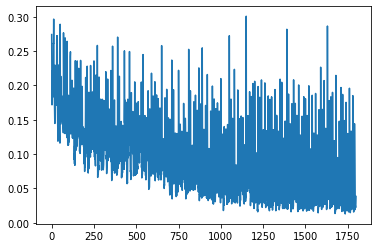

In [13]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array(range(len(loss)-2))
ypoints = loss[2:]

plt.plot(xpoints, ypoints)
plt.show()

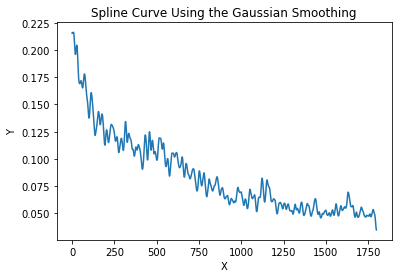

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d

x=np.array(range(len(loss)-2))
y=loss[2:]
y_smoothed = gaussian_filter1d(y, sigma=5)

plt.plot(x, y_smoothed)
plt.title("Spline Curve Using the Gaussian Smoothing")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()